# Notebook to generate figures

# Set model path and output folder

In [20]:
from pathlib import Path
output_dir = Path('_outputs_paper/EXP_2021-07-08-16:06:16_M015_AUGMENT_FINAL_rt-lamp-detr')
figoutdir = Path('test_fig')
figoutdir.mkdir(exist_ok=True)

# Import various library

In [10]:
from datasets import build_dataset, get_coco_api_from_dataset
import torch
from torch.utils.data import DataLoader, DistributedSampler
from pathlib import Path
from models import build_model
import pylab
from test_detr import predict_bbox, visualize_decoder_encoder_att, get_results, get_result_from_target, plot_confusion_matrix, backbone_features, visualize_decoder_encoder_att_combined
import time

# Generate augmented training images

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


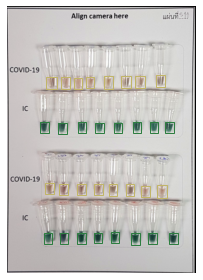

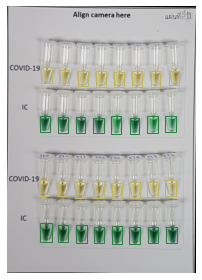

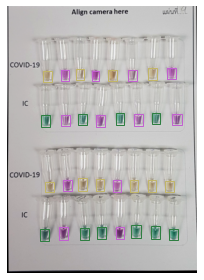

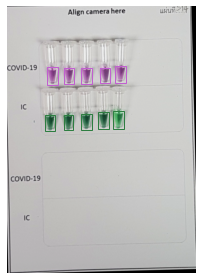

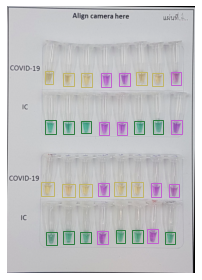

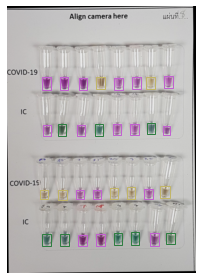

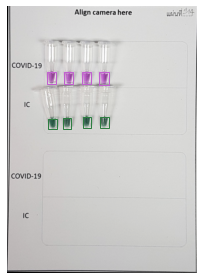

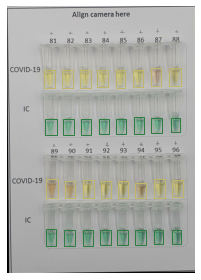

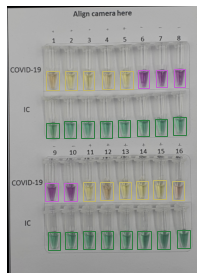

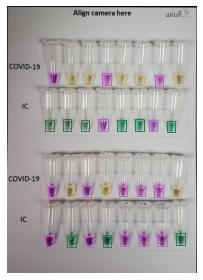

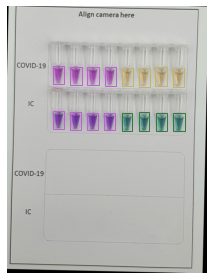

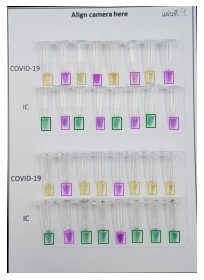

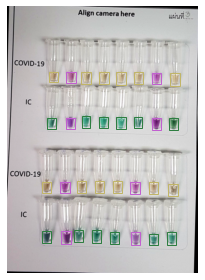

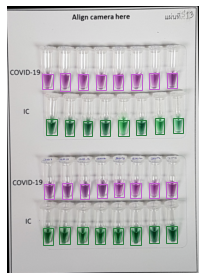

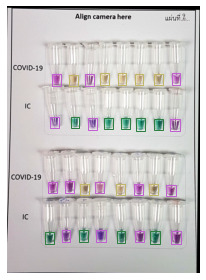

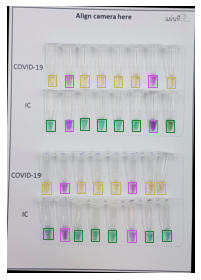

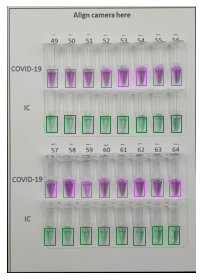

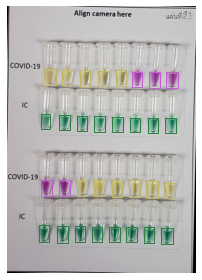

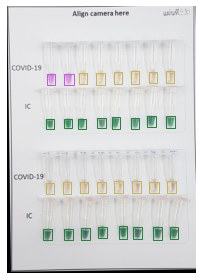

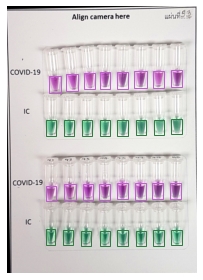

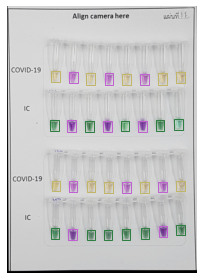

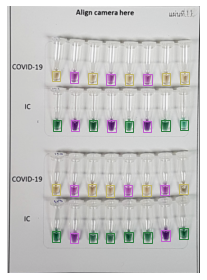

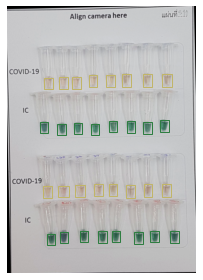

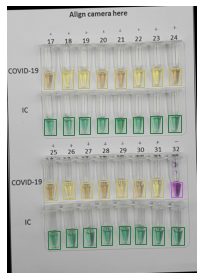

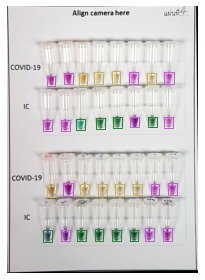

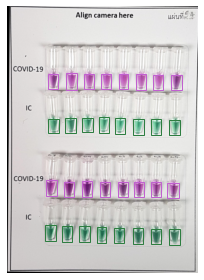

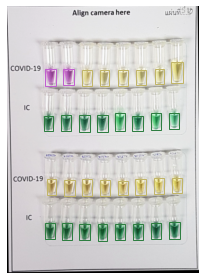

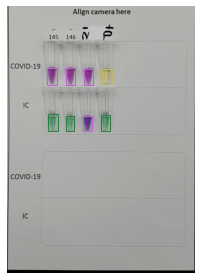

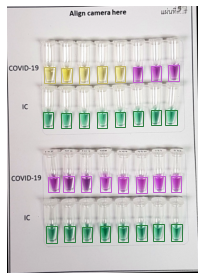

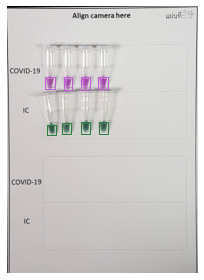

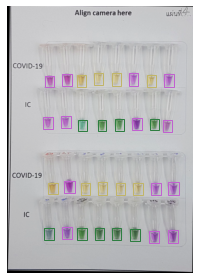

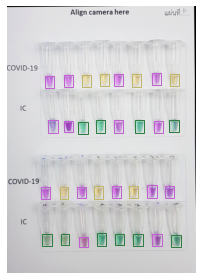

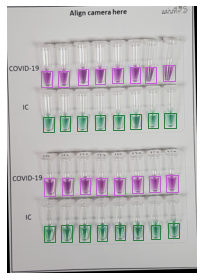

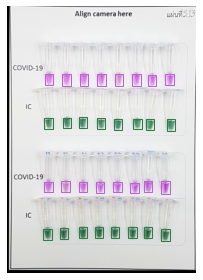

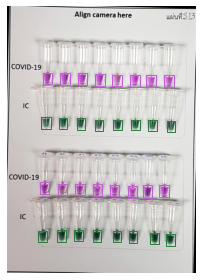

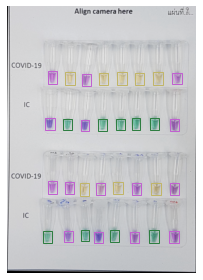

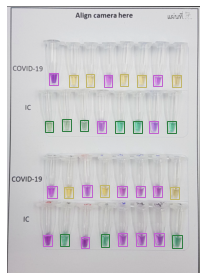

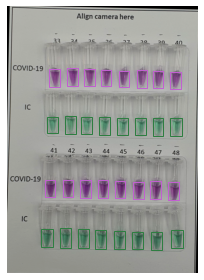

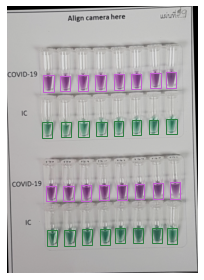

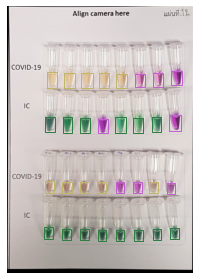

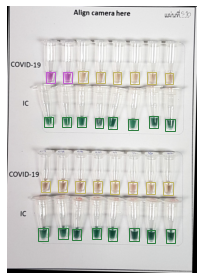

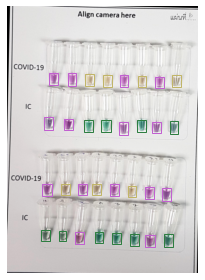

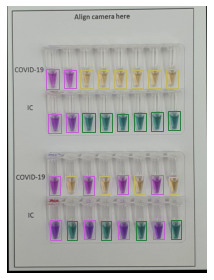

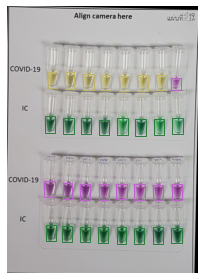

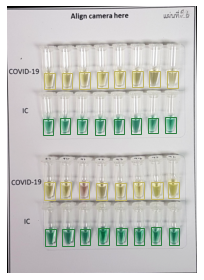

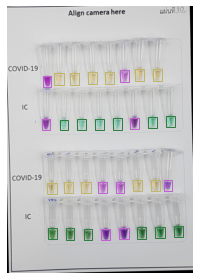

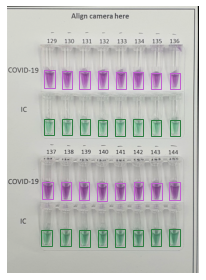

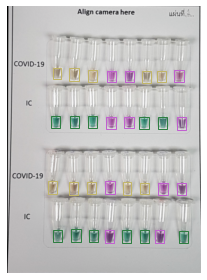

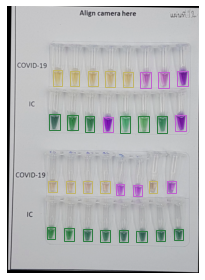

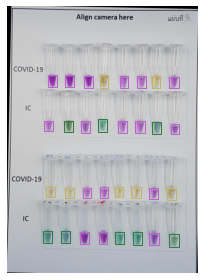

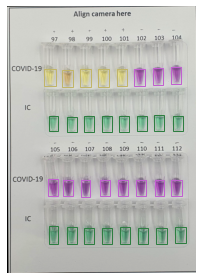

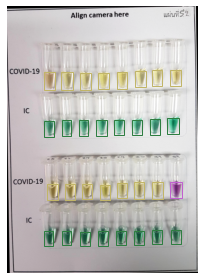

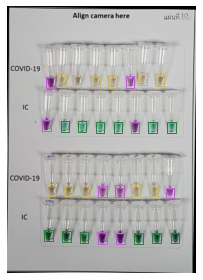

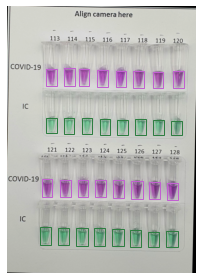

In [12]:
temp = torch.load(output_dir / 'best_accuracy_checkpoint.pth')
args = temp['args']
args.augment = True
output_dir_test = (output_dir / 'best_test')
output_dir_test.mkdir(exist_ok=True)

COLORS = [[194/256.,182/256.,104/256.],[46/256.,126/256.,65/256.],[194/256.,96/256.,209/256.]]

for i,(img,target) in enumerate(build_dataset(image_set='train', args=args, noTransforms=False, noNormalize=True)):
    pylab.figure()
    pylab.imshow(img.permute(1,2,0).cpu().numpy())
    ax = pylab.gca()
    boxes = target['boxes']
    labels = target['labels']
    colors = COLORS * 100
    for cl, (xmin, ymin, xmax, ymax), c in zip(labels, boxes.tolist(), colors):
        ax.add_patch(pylab.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=COLORS[cl], linewidth=1))
                
    pylab.axis('off')
    pylab.tight_layout()
    training_samples_folder = figoutdir / 'training_samples'
    training_samples_folder.mkdir(exist_ok=True)
    pylab.savefig(f'./{training_samples_folder}/augmented_training_samples_{i}.png')

# Generate attentions bbox and confusion matrix on test data

figoutdir test_fig
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Duration = 0.06862779706716537


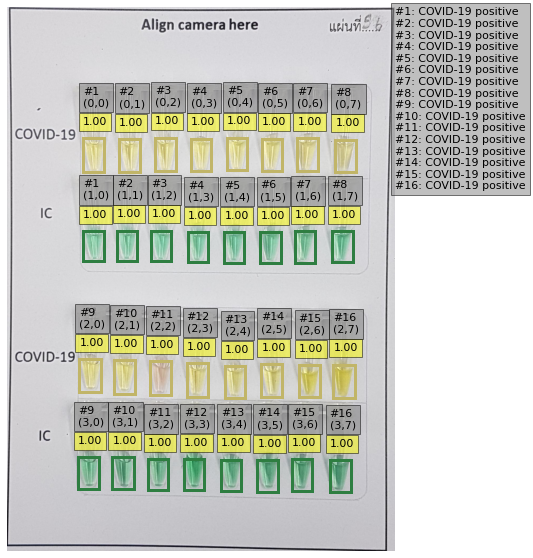

im.size, img.shape (1461, 2047) torch.Size([1, 3, 1120, 800])
Encoder attention:       torch.Size([875, 875])
Feature map:             torch.Size([1, 2048, 35, 25])
Encoder attention:       torch.Size([875, 875])
Feature map:             torch.Size([1, 2048, 35, 25])
Encoder attention:       torch.Size([875, 875])
Feature map:             torch.Size([1, 2048, 35, 25])
Encoder attention:       torch.Size([875, 875])
Feature map:             torch.Size([1, 2048, 35, 25])
Duration = 0.05980922793969512
Duration = 0.05881013162434101


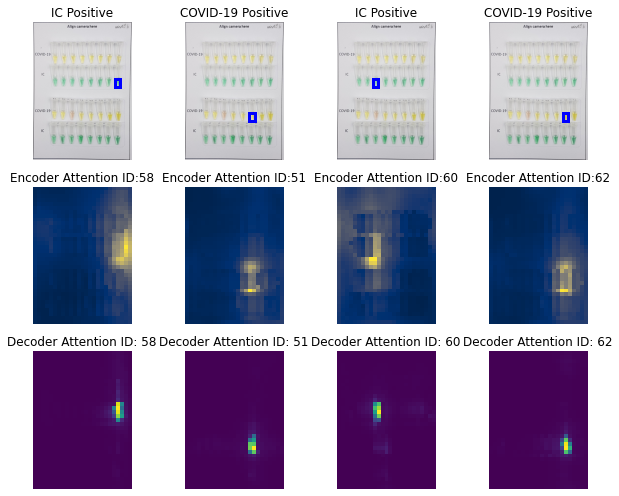

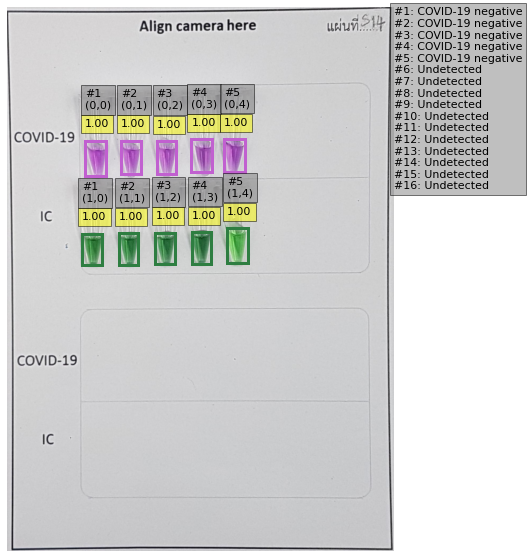

im.size, img.shape (1455, 2047) torch.Size([1, 3, 1125, 800])
Encoder attention:       torch.Size([900, 900])
Feature map:             torch.Size([1, 2048, 36, 25])
Encoder attention:       torch.Size([900, 900])
Feature map:             torch.Size([1, 2048, 36, 25])
Encoder attention:       torch.Size([900, 900])
Feature map:             torch.Size([1, 2048, 36, 25])
Encoder attention:       torch.Size([900, 900])
Feature map:             torch.Size([1, 2048, 36, 25])


In [ ]:
output_dir_test = (output_dir / 'best_test')
output_dir_test.mkdir(exist_ok=True)
device = torch.device('cuda')
print('figoutdir', figoutdir)

temp = torch.load(output_dir / 'best_accuracy_checkpoint.pth')
args = temp['args']

model, _, _ = build_model(args)
model.to(device)
model.load_state_dict(temp['model'])
model.eval()

sample_map = {}
sample_map[(0,0,1,0)] = 1
sample_map[(0,1,1,1)] = 2
sample_map[(0,2,1,2)] = 3
sample_map[(0,3,1,3)] = 4
sample_map[(0,4,1,4)] = 5
sample_map[(0,5,1,5)] = 6
sample_map[(0,6,1,6)] = 7
sample_map[(0,7,1,7)] = 8
sample_map[(2,0,3,0)] = 9
sample_map[(2,1,3,1)] = 10
sample_map[(2,2,3,2)] = 11
sample_map[(2,3,3,3)] = 12
sample_map[(2,4,3,4)] = 13
sample_map[(2,5,3,5)] = 14
sample_map[(2,6,3,6)] = 15
sample_map[(2,7,3,7)] = 16

idMap = {}
for k,v in sample_map.items():
    idMap[(k[0],k[1])] = v
    idMap[(k[2],k[3])] = v

# split bbox prediction
preds = []
targets = []
for i,(img,target) in enumerate(build_dataset(image_set='test', args=args, noTransforms=True)):
    fig = predict_bbox(model, img, device, threshold=0.7)
    fig.savefig(f'./{figoutdir}/test_bbox_{i}.png')

    fig = visualize_decoder_encoder_att_combined(model, img, device)
    fig.savefig(f'./{figoutdir}/test_decode_att_combined_{i}.png')

    results = get_results(model, img, device, threshold=0.7)
    tresults = get_result_from_target(target)
    preds += results.values()
    targets += tresults.values()
    
# calculate confusion matrix
fig = plot_confusion_matrix(targets, preds, labels=['COVID-19 positive', 'COVID-19 negative', 'RNA absent', 'False positive', 'Void'])
fig.savefig(f'./{figoutdir}/test_conf.svg') # png got cut off

# Generate backbone features images

In [ ]:
# Features
device = torch.device('cuda')

temp = torch.load(output_dir / 'best_accuracy_checkpoint.pth')
# temp = torch.load(output_dir / 'checkpoint.pth')
args = temp['args']
model, _, _ = build_model(args)
model.to(device)
model.load_state_dict(temp['model'])
model.eval()
args.augment = True

# args.custom_data_path = "./datasets/LAMP-XO-COVID_20210523/final"  
for i,(img,target) in enumerate(build_dataset(image_set='test', args=args, noTransforms=True)):
    features, pos = backbone_features(model, img, device)
    src, mask = features[-1].decompose()
    import pylab
    pylab.figure(figsize=(10,10))
    pylab.imshow(src.mean(1)[0,:,:].cpu().numpy())
    pylab.tight_layout()
    pylab.axis('off')
    pylab.savefig(f'./{figoutdir}/feature{i}.png')

# Timing measurements

In [ ]:
device = torch.device('cuda')
temp = torch.load(output_dir / 'best_accuracy_checkpoint.pth')
# temp = torch.load(output_dir / 'checkpoint.pth')
args = temp['args']
model, _, _ = build_model(args)
model.to(device)
model.load_state_dict(temp['model'])
model.eval()
args.augment = True

import datasets.transforms as T
normalize = T.Compose([
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
transform = T.Compose([
    T.RandomResize([800], max_size=1333),
    normalize,
])

total_time = 0
n_samples = 0

for i,(im,target) in enumerate(build_dataset(image_set='test', args=args, noTransforms=True)):
    # fig = predict_bbox(model, img, device, threshold=0.7)
    width,height = im.size
    im = transform(im, None)[0].unsqueeze(0)
    
    t_start = time.perf_counter_ns()
    outputs = model(im.to(device))
    t_end = time.perf_counter_ns()
    
    total_time += t_end-t_start
    n_samples += 1

print('avg', total_time/n_samples/16/1000/1000, 'ms')